Ignacio Vellido Expósito

In [8]:
################################################################################
# Libraries
################################################################################

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import layers
from keras import Sequential
from keras.layers import Dense, Dropout

from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, SGD

# Import the metrics from `sklearn.metrics`
from sklearn.metrics import r2_score

################################################################################

# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Airfoil Self-Noise Data Set
https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

## Data Set Information:

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

## Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [2]:
################################################################################
# Load data
################################################################################

# Read in white wine data 
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat',
                 sep="\t", names=["Hz", "Angle", "Length", "Velocity", "Displacement", "Db"])
df.head()

,Hz,Angle,Length,Velocity,Displacement,Db
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


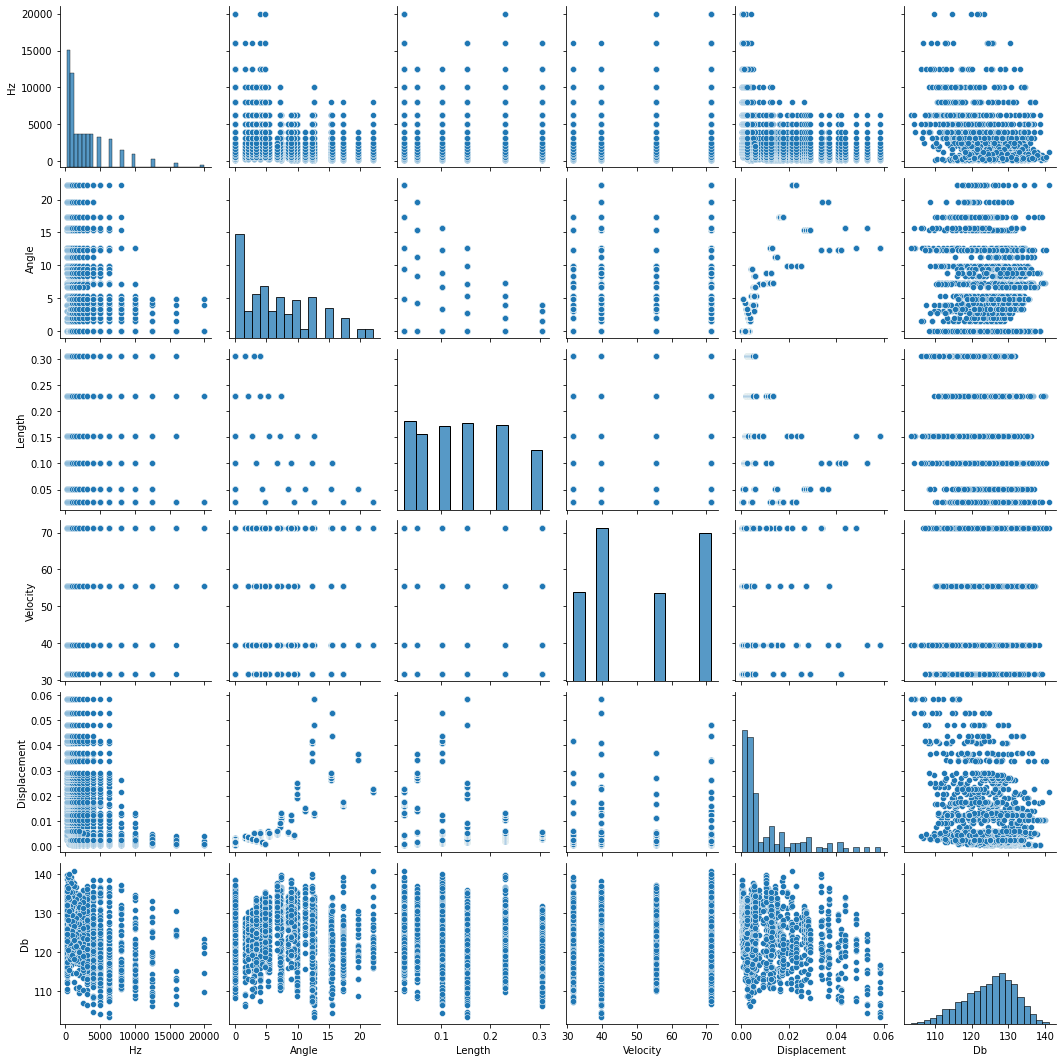

In [ ]:
################################################################################
# Visualize data
################################################################################

sns.pairplot(df)

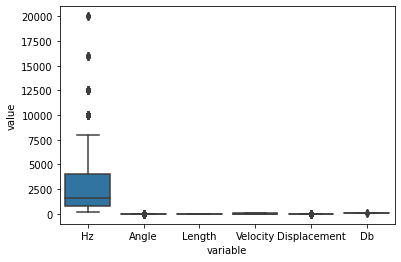

In [ ]:
sns.boxplot(x="variable", y="value", data=pd.melt(df))

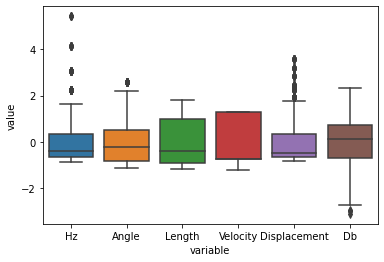

In [ ]:
# Scaled boxplot
scaled = StandardScaler().fit_transform(df)
scaled = pd.DataFrame(scaled, columns=["Hz", "Angle", "Length", "Velocity", "Displacement", "Db"])

sns.boxplot(x="variable", y="value", data=pd.melt(scaled))

In [ ]:
df.describe()

,Hz,Angle,Length,Velocity,Displacement,Db
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [ ]:
print("Instancias duplicadas: {}".format(len(df) - len(df.drop_duplicates())))

# Null values
nulls = df.isnull().sum(axis=1).tolist()
print("Valores nulos: {}".format(len([x for x in nulls if x > 0])))

Instancias duplicadas: 0
Valores nulos: 0


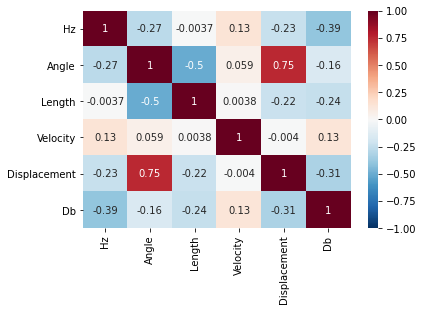

In [ ]:
corr = df.corr()
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap='RdBu_r',
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Conclusiones:
- Existe correlación entre Displacement-Angle y Length-Angle.
- Baja correlación entre Hz-Db, pero puede sernos útil para la regresión.
- No hay distribuciones normales

In [3]:
################################################################################
# Train-test split
################################################################################

y = df.Hz
x = df.drop(columns="Hz")

# Split the data up in train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [4]:
################################################################################
# Preprocessing data
################################################################################

# Define the scaler 
scaler = StandardScaler().fit(x_train)

# Scale the train set
x_train = scaler.transform(x_train)

# Scale the test set
x_test = scaler.transform(x_test)

In [38]:
################################################################################
# Define model
################################################################################

input_shape = x.shape

# Initialize the constructor
model = Sequential(
    [
      Dense(4, activation='relu', input_shape=(5,)),
      Dense(4, activation='relu'),  
      # Dropout(0.5),
      Dense(1)
    ]
)

# Model summary
print(model.summary())

################################################################################
# Fit model
################################################################################

# Parameters
batch_size = 20
epochs = 500
lr = 7e-3
decay = 1e-2

opt = RMSprop(lr=lr,
              # decay=decay
              )
# opt = SGD()

# Compile model
model.compile(optimizer=opt,
# model.compile(optimizer="rmsprop",
              loss='mse',
              metrics=['mae'])

early_callback = EarlyStopping(monitor='val_mae', 
                               patience=5,
                               restore_best_weights=True)

history = model.fit(x_train, 
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_callback], 
                    verbose=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 4)                 24        
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 5         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
49/49 [==============================] - 1s 5ms/step - loss: 16855282.3800 - mae: 2758.3394 - val_loss: 13784874.0000 - val_mae: 2590.9426
Epoch 2/500
49/49 [==============================] - 0s 2ms/step - loss: 17202071.0600 - mae: 2845.3044 - val_loss: 13685887.0000 - val_mae: 2572.9939
Epoch 3/500
49/49 [==============================] - 0s 2ms/step - loss: 1706393

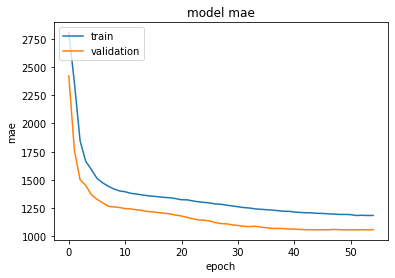

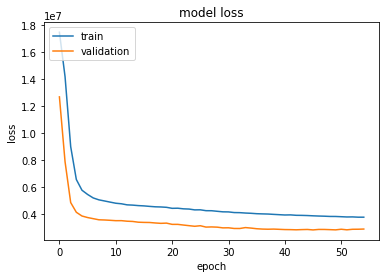

In [34]:
# Plot training history

# MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
################################################################################
# Test model
################################################################################

mse, mae = model.evaluate(x_test, y_test)

y_pred = model.predict(x_test)
r2 = r2_score(y_test,y_pred)

print("Lr:     {}".format(lr))
print("MSE:    {}".format(mse))
print("MAE:    {}".format(mae))
print("R2:     {}".format(r2))

10/10 [==============================] - 0s 2ms/step - loss: 4517755.5000 - mae: 1304.3154
Lr:     0.007
MSE:    4517755.5
MAE:    1304.3154296875
R2:     0.6500605274123411


Conclusiones:
- Una capa no es lo suficientemente potente para nuestro problema, pues no es ajustable linalmente.
- Un número excesivo de unidades tampoco ayuda al problema, con 12 unidades ocultas conseguimos mejores resultados que con más de 500.
- Lr por defecto de RMSProp hace que el aprendizaje sea lento, probablemente sea muy bajo y el momentum haga que pierda fuerza.
- A mayor número de capas/unidades, más inestable se vuelven las funciones de las métricas
- Dropout nos genera mayor varianza en la función de pérdida de validación.
- Con SGD nos explotan los gradientes por tener una función de pérdida tan alta.

- Obtenemos unos valores de MAE por encima de mil, que indica lo que de media nos alejamos en valor absoluto de la predicción correcta. Viendo que la desviación de nuesta función objetivo es muy baja, concluímos que lo resultados son malos.

- Independientemente de la arquitectura del modelo, notamos que el aprendizaje es excesivamente rápido. Aplanándose la función de pérdida en pocas épocas.
- Una vez más, se ve importante ajustar los parámetros del optimizador y aplicar regularización con EarlyStopping.
- Los resultados con 3 capas son engañosos, puesto que con 2 la red debería ser lo suficientemente potente para ajustar cualquier hiperplano.

---
## Resultados

2 capas, 8-4 unidades, Dropout 0.5, RMSprop
- Lr:     0.003
- MSE:    4244481.5
- MAE:    1257.944091796875
- R2:     0.6712279789835957

1 capa, 64 unidades, Dropout 0.5, RMSprop

- Lr:     0.0003
- MSE:    5881127.0
- MAE:    1545.394287109375
- R2:     0.5444555120490493

1 capa, 256 unidades, RMSProp

- Lr:     0.003
- MSE:    4594655.5
- MAE:    1323.3463134765625
- R2:     0.6486677730270624

2 capas, 256-128, Dropout 0.5, RMSProp

- Lr:     0.0003
- MSE:    4721643.0
- MAE:    1340.082275390625
- R2:     0.6389576492480797

2 capas, 64-64, Dropout 0.5, RMSprop

- Lr:     0.0003
- MSE:    4768226.0
- MAE:    1340.08642578125
- R2:     0.6306593806522061

3 capas, 64-32-64, Dropout 0.5, RMSprop

- Lr:     0.0003
- MSE:    4550466.0
- MAE:    1304.744873046875
- R2:     0.6475268148898023

2 capas, 128-64, Dropout 0.5, RMSprop

- Lr:     0.003
- MSE:    4477228.0
- MAE:    1289.2266845703125
- R2:     0.6531997748821651

2 capas, 256-256, Dropout 0.5, RMSprop
- Lr:     0.003
- MSE:    4132527.75
- MAE:    1245.0478515625
- R2:     0.6798997694727484

2 capas, 512-256, Dropout 0.5, RMSprop
- Lr:     0.003
- MSE:    3961898.5
- MAE:    1222.608154296875
- R2:     0.6931165029733839

1 capas, 4-4 unidades, Dropout 0.5, Batch=15, RMSprop

- Lr:     0.007
- MSE:    4517755.5
- MAE:    1304.3154296875
- R2:     0.6500605274123411